In [342]:
# 3rd Party Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import folium
from folium.plugins import HeatMap
from folium import Choropleth
from folium.plugins import TimestampedGeoJson

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [343]:
# Import Real Estate Data
real_estate = pd.read_csv("../2_data_cleaning/cleaned_csv/housesigma_data_2003_with_coords_date.csv")

# Convert to GeoDataFrame
real_estate['geometry'] = real_estate.apply(lambda row: Point(row['long'], row['lat']), axis=1)
real_estate = gpd.GeoDataFrame(real_estate, geometry='geometry')
real_estate.drop(columns=["lat", "long"], inplace=True)
real_estate.set_crs("EPSG:4326", inplace=True)

# View DataFrame
real_estate.head()

,Unnamed: 0,link,strikethrough_price,sold_price,property_type,address,date,standardized_date,geometry
0,0,/on/toronto-real-estate/74-mortimer-ave/home/R...,"$1,159,000","$1,145,000",Semi-Detached,"74 mortimer ave , toronto - broadview north",1 day ago,2024-11-29 17:59:11.298791,POINT EMPTY
1,1,/on/toronto-real-estate/6-newmarket-ave/home/B...,"$1,050,000","$980,000",Detached,"6 newmarket ave , toronto - woodbine-lumsden",1 day ago,2024-11-29 17:59:11.298791,POINT (-79.30764 43.68939)
2,2,/on/toronto-real-estate/112-rosethorn-ave/home...,"$789,000","$930,000",Semi-Detached,"112 rosethorn ave , toronto - weston-pellam park",1 day ago,2024-11-29 17:59:11.298791,POINT (-79.46339 43.6796)
3,3,/on/toronto-real-estate/82-bowie-ave/home/0J6E...,"$1,239,000","$1,228,018",Detached,"82 bowie ave , toronto - briar hill-belgravia",2 days ago,2024-11-28 17:59:11.298791,POINT (-79.45537 43.69686)
4,4,/on/toronto-real-estate/1275-woodbine-ave/home...,"$899,000","$905,500",Detached,"1275 woodbine ave , toronto - woodbine-lumsden",2 days ago,2024-11-28 17:59:11.298791,POINT EMPTY


In [344]:
# View Summary of Real Estate Data
real_estate.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 88000 entries, 0 to 87999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Unnamed: 0           88000 non-null  int64   
 1   link                 88000 non-null  object  
 2   strikethrough_price  88000 non-null  object  
 3   sold_price           87587 non-null  object  
 4   property_type        87587 non-null  object  
 5   address              88000 non-null  object  
 6   date                 87587 non-null  object  
 7   standardized_date    87587 non-null  object  
 8   geometry             88000 non-null  geometry
dtypes: geometry(1), int64(1), object(7)
memory usage: 6.0+ MB


In [345]:
# Clean Real Estate Data
# Drop Unnecessary Columsn
real_estate = real_estate.drop(columns=["Unnamed: 0", "strikethrough_price", "date", "link"])

# Drop Rows with No Geometry Location
real_estate = real_estate[~real_estate.geometry.is_empty]

# Convert Date to DateTime Format and Drop NA Values
real_estate = real_estate.dropna(subset=['standardized_date'])
real_estate['standardized_date'] = pd.to_datetime(real_estate['standardized_date'], format = "mixed").dt.date

# Convert Sold Price to Integer Format
real_estate['sold_price'] = real_estate['sold_price'].replace('[\$,]', '', regex=True).astype(float)

# Add Year Column for Analysis over Time
real_estate['year'] = pd.to_datetime(real_estate['standardized_date']).dt.year.astype(int)

# Reset Index
real_estate = real_estate.reset_index(drop=True)

# View DataFrame
real_estate.head(20)

,sold_price,property_type,address,standardized_date,geometry,year
0,980000.0,Detached,"6 newmarket ave , toronto - woodbine-lumsden",2024-11-29,POINT (-79.30764 43.68939),2024
1,930000.0,Semi-Detached,"112 rosethorn ave , toronto - weston-pellam park",2024-11-29,POINT (-79.46339 43.6796),2024
2,1228018.0,Detached,"82 bowie ave , toronto - briar hill-belgravia",2024-11-28,POINT (-79.45537 43.69686),2024
3,1525000.0,Semi-Detached,"145 ronan ave , toronto - lawrence park north",2024-11-28,POINT (-79.39523 43.73057),2024
4,1975000.0,Detached,"44 endean ave , toronto - south riverdale",2024-11-28,POINT (-79.33342 43.66915),2024
5,1318500.0,Semi-Detached,"100 caroline ave , toronto - south riverdale",2024-11-28,POINT (-79.33529 43.66142),2024
6,985000.0,Semi-Detached,"12 livingstone ave , toronto - briar hill-belg...",2024-11-28,POINT (-79.4399 43.69894),2024
7,1860000.0,Detached,"228 donlands ave , toronto - danforth village-...",2024-11-28,POINT (-79.34073 43.68806),2024
8,3735000.0,Detached,"228 owen blvd , north york - st. andrew-windfi...",2024-11-27,POINT (-79.38485 43.74902),2024
9,850000.0,Semi-Detached,"55 deanscroft sq , scarborough - west hill",2024-11-27,POINT (-79.17645 43.76491),2024


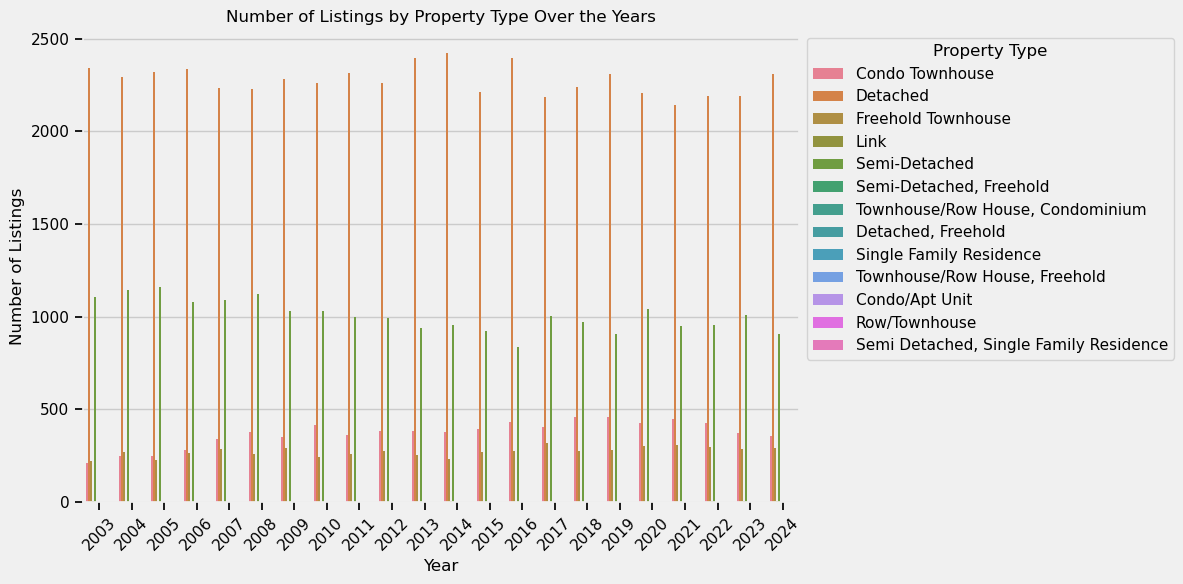

In [346]:
# Explore Property Type Column
# Group Data by Year and Property Type
grouped_data = real_estate.groupby(['year', 'property_type']).size().reset_index(name='count')

# Plot Data
plt.figure(figsize=(12, 6))
sns.barplot(data = grouped_data, x = "year", y = "count", hue = "property_type")
plt.title("Number of Listings by Property Type Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Listings")
plt.legend(title = "Property Type", loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation = 45)
plt.tight_layout() 
plt.show()

In [347]:
# For Consistent Comparison, We Will be Using Detached Home Data Only and Will Drop All Other Property Types
# This Reflects the Fact that We Have the Most Data for Detached Homes and Its Roughly Constant Over Time
real_estate = real_estate[real_estate["property_type"] == "Detached"]

In [348]:
# Calculate Price Statistics
real_estate["sold_price"].describe()

count    5.006300e+04
mean     1.114620e+06
std      1.047147e+06
min      1.700000e+03
25%      4.780000e+05
50%      8.254000e+05
75%      1.365000e+06
max      2.385000e+07
Name: sold_price, dtype: float64

In [349]:
# It Can be Seen There are Very Low Prices That May Be Rental Prices Being Used in Replacement of Sold Prices
# We Can Remove These Prices Using the IQR Method
# Calculate IQR
Q1 = real_estate['sold_price'].quantile(0.25)
Q3 = real_estate['sold_price'].quantile(0.75)
IQR = Q3 - Q1

# Define Lower and Upper Bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

Lower Bound: -852500.0
Upper Bound: 2695500.0


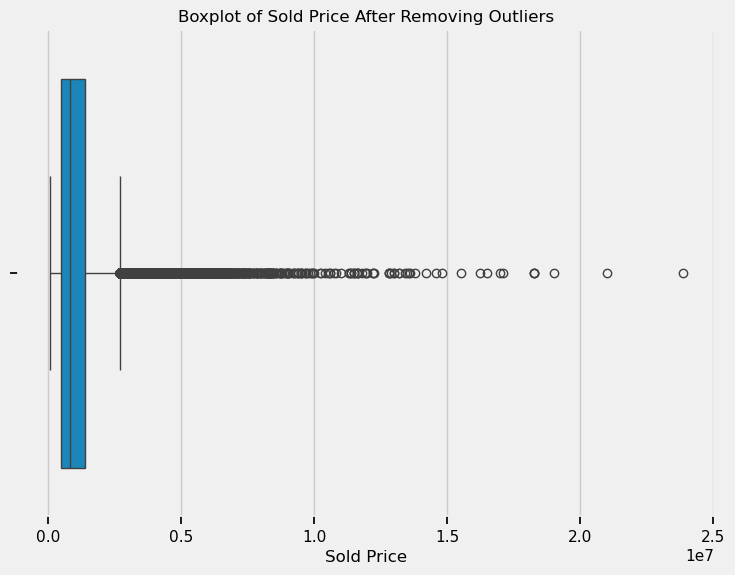

In [350]:
# It Needs to Be Noted That the Lower Bound is Unrealistic and That It Is Highly Likely That Houses are Being Sold Above the Upper Bound. 
# As Such a Filter of Roughly $10,000 Will Be Used Based on Industry Knowledge to Remove Rental Prices from the Data
# Remove Outliers
real_estate = real_estate[(real_estate['sold_price'] >= 10000)]

# Plot Data
plt.figure(figsize = (8, 6))
sns.boxplot(data = real_estate, x = "sold_price")
plt.title("Boxplot of Sold Price After Removing Outliers")
plt.xlabel("Sold Price")
plt.show()

In [351]:
# Calculate Price Statistics Again
real_estate["sold_price"].describe()

count    5.006100e+04
mean     1.114665e+06
std      1.047145e+06
min      6.650000e+04
25%      4.780000e+05
50%      8.255000e+05
75%      1.365000e+06
max      2.385000e+07
Name: sold_price, dtype: float64

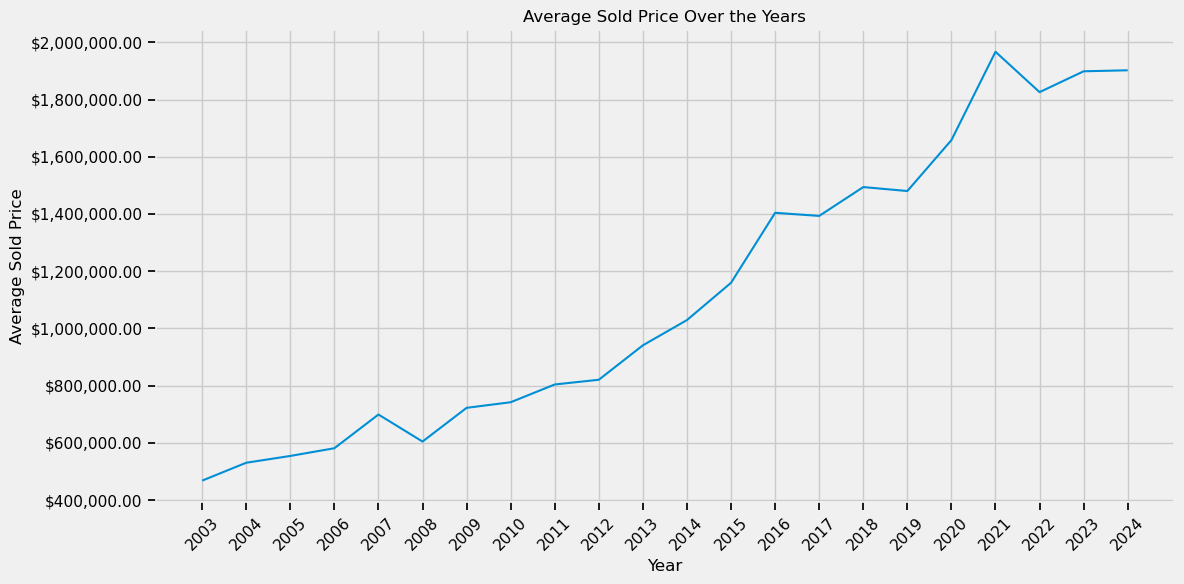

In [352]:
# Explore Price Column
# Group Data by Year and Sold Price
avg_price_per_year = real_estate.groupby("year")["sold_price"].mean().reset_index()

# Plot Data
plt.figure(figsize=(12, 6))
sns.lineplot(data = avg_price_per_year, x = "year", y = "sold_price")
plt.title("Average Sold Price Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Sold Price")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"${x:,.2f}"))
plt.xticks(avg_price_per_year["year"], rotation = 45)
plt.tight_layout()
plt.show()

In [353]:
# As Can Be Seen There is a General Increase in the Average Sold Price Over the Years Due to Inflation and Population Growth.
# There is a Dip in 2007 Due to the Global Financial Crisis in 2008 Whic Led to a Sharp Decline in Housing Prices
# There is a Dip in 2021 Due to the COVID-19 Pandemic ands Its Resulting Lockdowns and Economic Uncertainty
# This Goes to Show that Housing Prices are Very Closely Correlated with Economic Conditions of the Market

In [354]:
# Explore Geographic Distribution of Houses
# Import Census Data and Create GeoDataFrame
census = gpd.read_file("../0_raw_data/census_data/Neighbourhoods - 4326.shp")

# Merge DataSets with Spatial Join
real_estate = gpd.sjoin(real_estate, census, how = "left", predicate = "within")

# Drop Unnecessary Columns
real_estate = real_estate.drop(["index_right", "_id1", "AREA_ID2", "AREA_AT3", "PARENT_4", "AREA_SH5", "AREA_LO6", "AREA_DE8", "CLASSIF9", "CLASSIF10", "OBJECTI11"], axis = 1)

# Rename Columns 
real_estate = real_estate.rename(columns={'AREA_NA7': 'neighbourhood'})

# View DataFrame
real_estate.head()

,sold_price,property_type,address,standardized_date,geometry,year,neighbourhood
0,980000.0,Detached,"6 newmarket ave , toronto - woodbine-lumsden",2024-11-29,POINT (-79.30764 43.68939),2024,East End-Danforth
2,1228018.0,Detached,"82 bowie ave , toronto - briar hill-belgravia",2024-11-28,POINT (-79.45537 43.69686),2024,Briar Hill-Belgravia
4,1975000.0,Detached,"44 endean ave , toronto - south riverdale",2024-11-28,POINT (-79.33342 43.66915),2024,South Riverdale
7,1860000.0,Detached,"228 donlands ave , toronto - danforth village-...",2024-11-28,POINT (-79.34073 43.68806),2024,Danforth East York
8,3735000.0,Detached,"228 owen blvd , north york - st. andrew-windfi...",2024-11-27,POINT (-79.38485 43.74902),2024,St.Andrew-Windfields


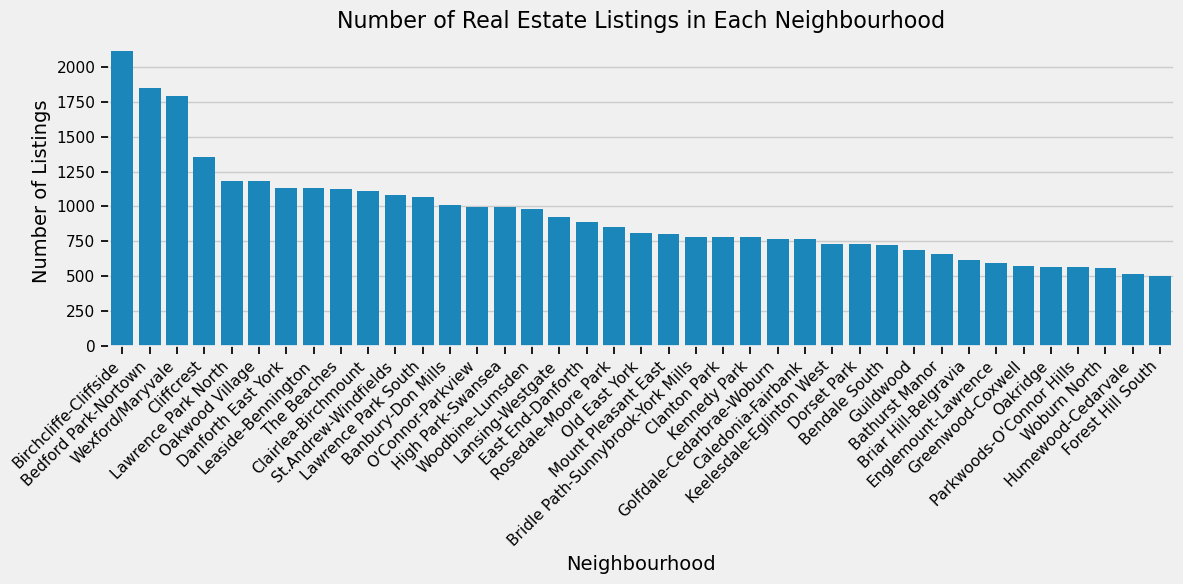

In [355]:
# Explore Neighbourhood Column
# Count Houses in Each Neighbourhood
neighbourhood_counts = real_estate["neighbourhood"].value_counts()

# Limit to Those Neighbourhoods with More than 500 Houses
neighbourhood_counts = neighbourhood_counts[neighbourhood_counts > 500]

# Create Bar Plot
plt.figure(figsize = (12, 6))
sns.barplot(x = neighbourhood_counts.index, y = neighbourhood_counts.values)
plt.xlabel("Neighbourhood", fontsize = 14)
plt.ylabel("Number of Listings", fontsize = 14)
plt.title("Number of Real Estate Listings in Each Neighbourhood", fontsize = 16)
plt.xticks(rotation = 45, ha = "right")
plt.tight_layout()
plt.show()

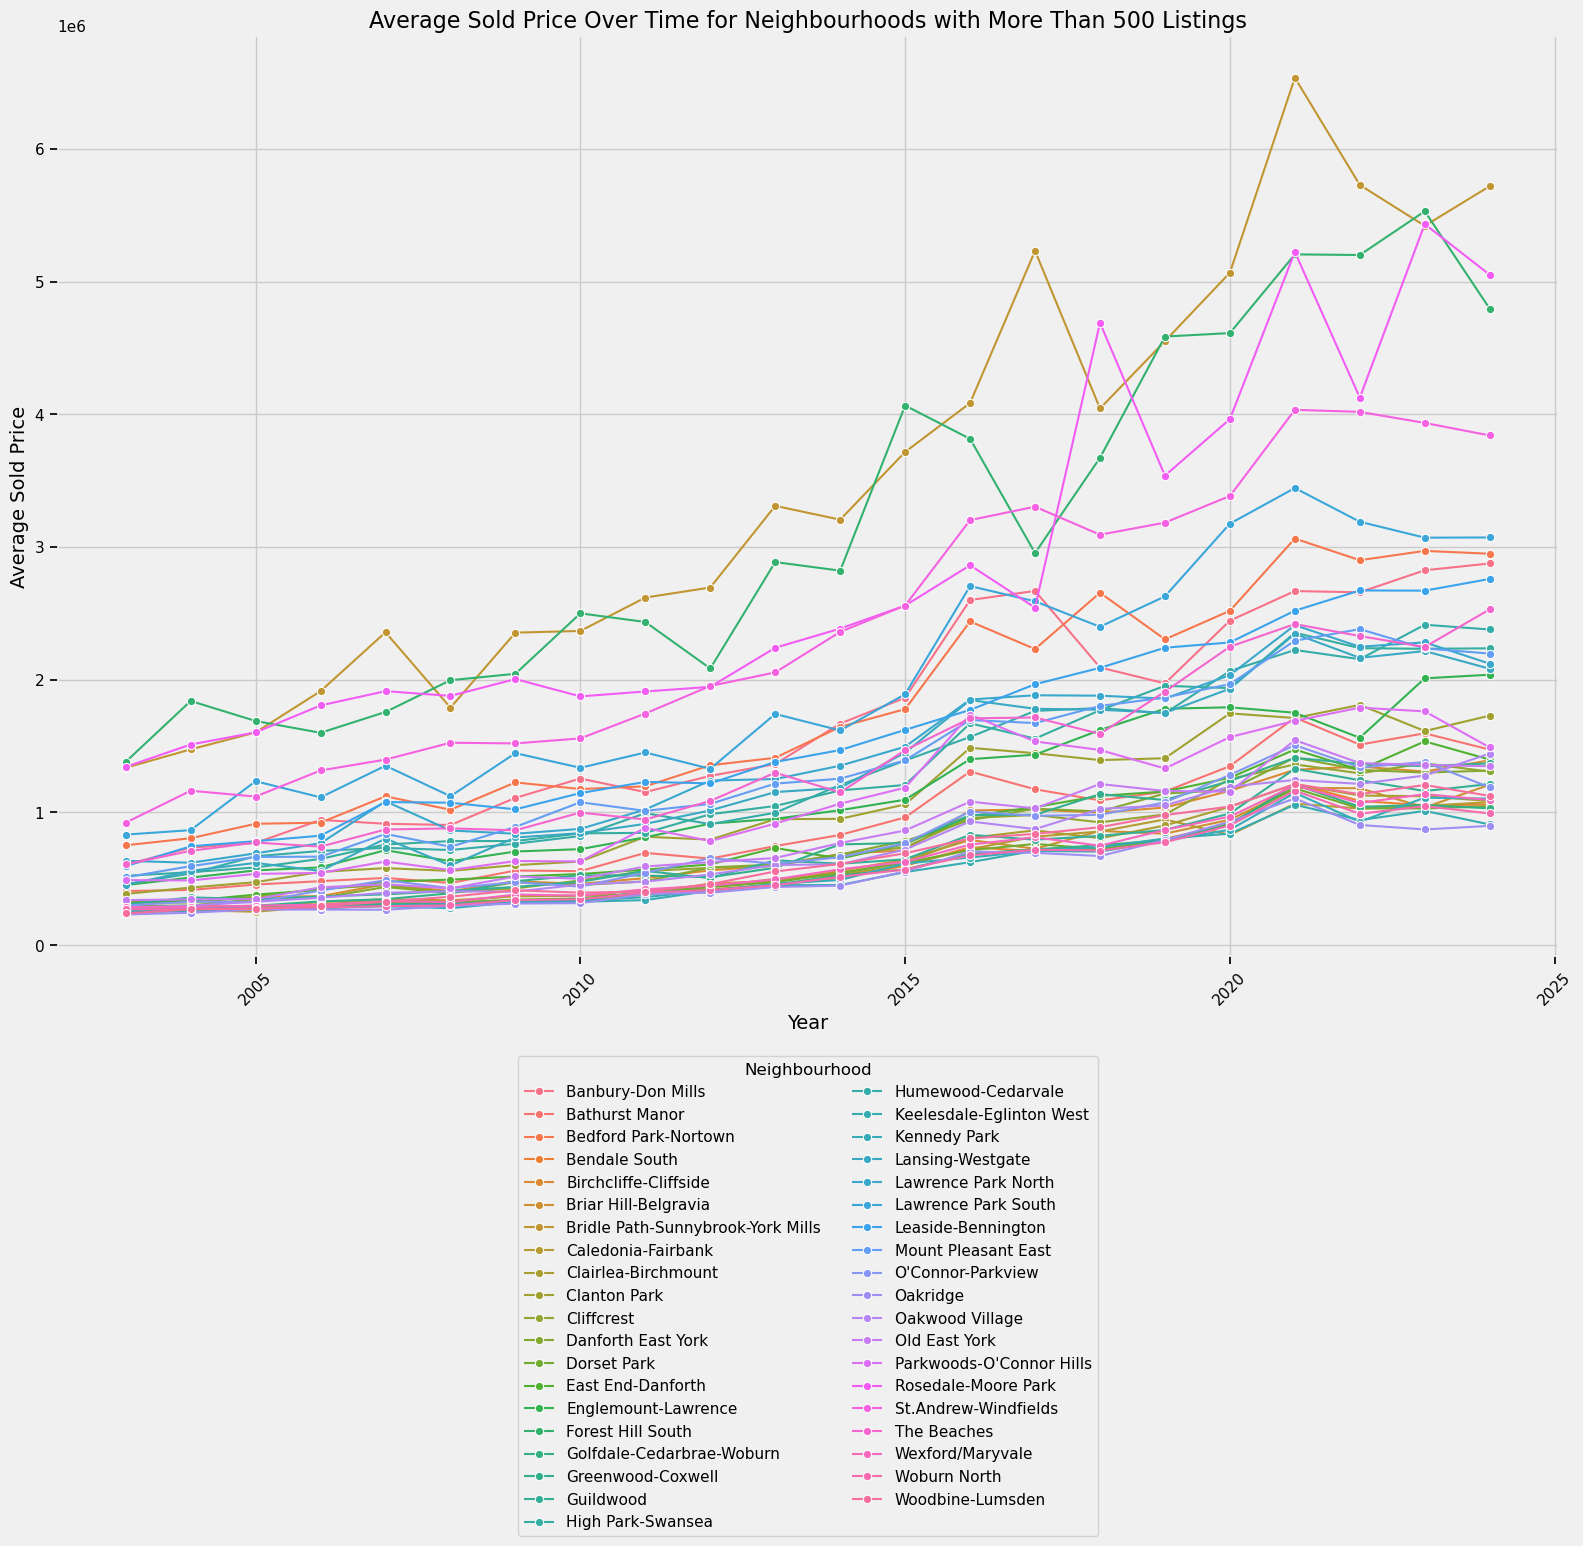

In [356]:
# Filter Data to Show Neighbourhoods with Sufficient Houses
filtered_real_estate = real_estate[real_estate["neighbourhood"].isin(neighbourhood_counts.index)]

# Group Data by Neighbourhood and Year
avg_price_by_neighbourhood = filtered_real_estate.groupby(["neighbourhood", "year"])["sold_price"].mean().reset_index()

# Plot Line Plot
plt.figure(figsize = (16, 16)) 
sns.lineplot(data = avg_price_by_neighbourhood, x = "year", y = "sold_price", hue = "neighbourhood", marker = "o")
plt.xlabel("Year", fontsize = 14)
plt.ylabel("Average Sold Price", fontsize = 14)
plt.title("Average Sold Price Over Time for Neighbourhoods with More Than 500 Listings", fontsize = 16)
plt.xticks(rotation = 45)
plt.legend(title = "Neighbourhood", bbox_to_anchor = (0.5, -0.1), loc = "upper center", ncol = 2)
plt.tight_layout() 
plt.show()


In [357]:
# We Can Notice That All Neighbourhoods Are Following a Similar Trend in Prices Over Time Irrespective of the Varying Social Infrastructure Present in Each One.
# We Can Also Note That High-End Neighbourhoods Such as Bridle Path-Sunnybrook-York Mills, Rosedale-Moore Park, Forest Hill South Show Alot More Fluctuation, But This Can be Seen as Normal for These Markets as They Are Influened Differently by Economic Conditions.

In [380]:
# Plot Folium Map of Average Home Prices per Nieghbourhood Over Time